# 사전준비
## OpenAI 설정

In [62]:
#| label: openai-setup
import openai
import os

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())

openai.api_key  = os.getenv('ENV_OPENAI_API_KEY')

## 데이터셋

In [63]:
#| label: penguins-dataset
# !pip install palmerpenguins
import pandas as pd
from palmerpenguins import load_penguins

penguins_raw = load_penguins()
penguins_raw.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


## 결측값
### 결측값 현황

In [64]:
#| label: missing-values
def show_missing(df):
    """Return a Pandas dataframe describing the contents of a source dataframe including missing values."""
    
    variables = []
    dtypes = []
    count = []
    unique = []
    missing = []
    pc_missing = []
    
    for item in df.columns:
        variables.append(item)
        dtypes.append(df[item].dtype)
        count.append(len(df[item]))
        unique.append(len(df[item].unique()))
        missing.append(df[item].isna().sum())
        pc_missing.append(round((df[item].isna().sum() / len(df[item])) * 100, 2))

    output = pd.DataFrame({
        'variable': variables, 
        'dtype': dtypes,
        'count': count,
        'unique': unique,
        'missing': missing, 
        'pc_missing': pc_missing
    })    
        
    return output
# penguins.isna().sum()
show_missing(penguins_raw)

,variable,dtype,count,unique,missing,pc_missing
0,species,object,344,3,0,0.00
1,island,object,344,3,0,0.00
2,bill_length_mm,float64,344,165,2,0.58
3,bill_depth_mm,float64,344,81,2,0.58
4,flipper_length_mm,float64,344,56,2,0.58
5,body_mass_g,float64,344,95,2,0.58
6,sex,object,344,3,11,3.20
7,year,int64,344,3,0,0.00


### 결측값 제거

In [74]:
#| label: missing-values-remove
# !pip install llama-index
# penguins = penguins_raw.dropna()

import pandas as pd
from llama_index.indices.struct_store import GPTPandasIndex

penguins_raw_idx = GPTPandasIndex(df=penguins_raw)
raw_query_engine = penguins_raw_idx.as_query_engine(verbose=True)
response = raw_query_engine.query("""remove NaN values from the dataframe""")
# response = query_engine.query("""What is the pairwise correlation of the float64 datatype columns""")
 
print(response.response)

> Pandas Instructions:
```

df.dropna()
```
> Pandas Output:        species     island  bill_length_mm  bill_depth_mm  flipper_length_mm   
0       Adelie  Torgersen            39.1           18.7              181.0  \
1       Adelie  Torgersen            39.5           17.4              186.0   
2       Adelie  Torgersen            40.3           18.0              195.0   
4       Adelie  Torgersen            36.7           19.3              193.0   
5       Adelie  Torgersen            39.3           20.6              190.0   
..         ...        ...             ...            ...                ...   
339  Chinstrap      Dream            55.8           19.8              207.0   
340  Chinstrap      Dream            43.5           18.1              202.0   
341  Chinstrap      Dream            49.6           18.2              193.0   
342  Chinstrap      Dream            50.8           19.0              210.0   
343  Chinstrap      Dream            50.2           18.7              

# 챗GPT 데이터 연결

In [73]:
#| label: llama-setup

penguins = penguins_raw.dropna()

penguins_idx = GPTPandasIndex(df=penguins)
query_engine = penguins_idx.as_query_engine(verbose=True)

#response = query_engine.query("""데이터셋에 있는 행 수와 열 수를 반환합니다.\n
#                                 응답은 다음 태그에 표시된 대로 키-값 객체여야 합니다.\n 
#                                 <{'행':..., '열':...}>""")

response = query_engine.query("""Return how many rows and how many columns are in the dataset.\n
                                 The response must be a key-value object as we show in the tags:\n 
                                 <{'rows':..., 'columns':...}>""")
 
print(response.response)

> Pandas Instructions:
```
{'rows': df.shape[0], 'columns': df.shape[1]}
```
> Pandas Output: {'rows': 333, 'columns': 8}
{'rows': 333, 'columns': 8}


# 데이터 살펴보기

In [67]:
penguins.info()

<class 'pandas.core.frame.DataFrame'>
Index: 333 entries, 0 to 343
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            333 non-null    object 
 1   island             333 non-null    object 
 2   bill_length_mm     333 non-null    float64
 3   bill_depth_mm      333 non-null    float64
 4   flipper_length_mm  333 non-null    float64
 5   body_mass_g        333 non-null    float64
 6   sex                333 non-null    object 
 7   year               333 non-null    int64  
dtypes: float64(4), int64(1), object(3)
memory usage: 23.4+ KB


# 상관관계

In [68]:
#| label: llama-correlation
response = query_engine.query("""list the float64 datatype columns and calculate the pairwise correlation of the float64 datatype columns""")
# response = query_engine.query("""What is the pairwise correlation of the float64 datatype columns""")
 
print(response.response)

> Pandas Instructions:
```

df.select_dtypes(include=['float64']).corr(method='pearson')
```
> Pandas Output:                    bill_length_mm  bill_depth_mm  flipper_length_mm   
bill_length_mm           1.000000      -0.228626           0.653096  \
bill_depth_mm           -0.228626       1.000000          -0.577792   
flipper_length_mm        0.653096      -0.577792           1.000000   
body_mass_g              0.589451      -0.472016           0.872979   

                   body_mass_g  
bill_length_mm        0.589451  
bill_depth_mm        -0.472016  
flipper_length_mm     0.872979  
body_mass_g           1.000000  
                   bill_length_mm  bill_depth_mm  flipper_length_mm   
bill_length_mm           1.000000      -0.228626           0.653096  \
bill_depth_mm           -0.228626       1.000000          -0.577792   
flipper_length_mm        0.653096      -0.577792           1.000000   
body_mass_g              0.589451      -0.472016           0.872979   

             

# 요약통계량

In [69]:
#| label: llama-summary
response = query_engine.query("""list the float64 datatype columns and calcuate the average values by species""")
 
print(response.response)

> Pandas Instructions:
```

df.groupby('species')[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']].mean().reset_index()
```
> Pandas Output:      species  bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g
0     Adelie       38.823973      18.347260         190.102740  3706.164384
1  Chinstrap       48.833824      18.420588         195.823529  3733.088235
2     Gentoo       47.568067      14.996639         217.235294  5092.436975
     species  bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g
0     Adelie       38.823973      18.347260         190.102740  3706.164384
1  Chinstrap       48.833824      18.420588         195.823529  3733.088235
2     Gentoo       47.568067      14.996639         217.235294  5092.436975


# 시각화
## 산점도

> Pandas Instructions:
```

df.plot.scatter(x='body_mass_g', y='flipper_length_mm')
```
> Pandas Output: Axes(0.125,0.11;0.775x0.77)
Axes(0.125,0.11;0.775x0.77)


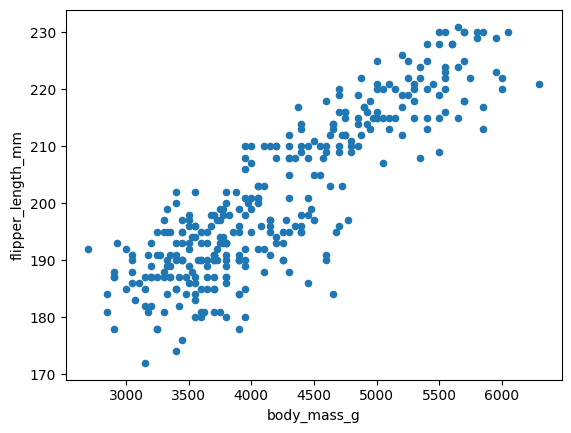

In [70]:
#| label: llama-scatter
response = query_engine.query("""visualize two columns; body_mass_g and flipper_length_mm with scatterplot""")
 
print(response.response)

## 히스토그램

> Pandas Instructions:
```

df.groupby('species')['body_mass_g'].plot.kde(legend=True, alpha=0.5)
```
> Pandas Output: species
Adelie       Axes(0.125,0.11;0.775x0.77)
Chinstrap    Axes(0.125,0.11;0.775x0.77)
Gentoo       Axes(0.125,0.11;0.775x0.77)
Name: body_mass_g, dtype: object
species
Adelie       Axes(0.125,0.11;0.775x0.77)
Chinstrap    Axes(0.125,0.11;0.775x0.77)
Gentoo       Axes(0.125,0.11;0.775x0.77)
Name: body_mass_g, dtype: object


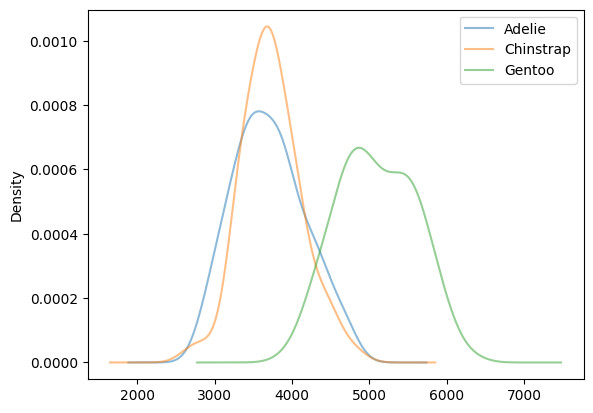

In [71]:
#| label: llama-histogram
# import seaborn as sns
response = query_engine.query("""draw distribution plot for body_mass_g with transparency by species with legend""")
 
print(response.response)

# 모형

In [72]:
#| label: llama-model
# !pip install -U scikit-learn
from sklearn.linear_model import LogisticRegression
response = query_engine.query("""build a `sex` classification model using logistic regression step-by-step""")
 
print(response.response)

> Pandas Instructions:
```

eval('LogisticRegression().fit(df[["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]], df["sex"]).predict(df[["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]])')
```
> Pandas Output: There was an error running the output as Python code. Error message: name 'LogisticRegression' is not defined
There was an error running the output as Python code. Error message: name 'LogisticRegression' is not defined


Traceback (most recent call last):
  File "C:\Users\statkclee\anaconda3\lib\site-packages\llama_index\indices\struct_store\pandas_query.py", line 58, in default_output_processor
    raise e
  File "C:\Users\statkclee\anaconda3\lib\site-packages\llama_index\indices\struct_store\pandas_query.py", line 56, in default_output_processor
    return str(eval(module_end_str, {}, local_vars))
  File "<string>", line 1, in <module>
  File "<string>", line 1, in <module>
NameError: name 'LogisticRegression' is not defined
